# Import

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndimage

# Hyperparameter

In [2]:
IMG_SIZE = 256
BATCH_SIZE = 32
NUM_EPOCHS = 30
LEARNING_RATE = 0.001
base_seg_path = "/kaggle/input/brisc2025/brisc2025/segmentation_task"
base_cls_path = "/kaggle/input/brisc2025/brisc2025/classification_task"
CHECKPOINT_PATH_SEG = "/kaggle/working/seg_checkpoint.pth"
CHECKPOINT_PATH_CLS = "/kaggle/working/cls_checkpoint.pth"
CHECKPOINT_PATH_JOINT = "/kaggle/working/joint_checkpoint.pth"
BEST_MODEL_PATH_SEG = "/kaggle/working/best_seg_model.pth"
BEST_MODEL_PATH_CLS = "/kaggle/working/best_cls_model.pth"
BEST_MODEL_PATH_JOINT = "/kaggle/working/best_joint_model.pth"

# Pre-processing

In [3]:
class BinaryMorphology:
    def __init__(self, operation='dilation', kernel_size=3, iterations=1):
        self.operation = operation
        self.kernel_size = kernel_size
        self.iterations = iterations
        self.kernel = np.ones((kernel_size, kernel_size), dtype=np.float32)

    def __call__(self, mask):
        mask_np = mask.numpy().squeeze()  
        if self.operation == 'dilation':
            mask_np = ndimage.binary_dilation(mask_np, structure=self.kernel, iterations=self.iterations).astype(np.float32)
        elif self.operation == 'erosion':
            mask_np = ndimage.binary_erosion(mask_np, structure=self.kernel, iterations=self.iterations).astype(np.float32)
        return torch.tensor(mask_np, dtype=torch.float32).unsqueeze(0)  

# Pipeline
image_transform = T.Compose([
    T.ToTensor(),  
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.GaussianBlur(kernel_size=3, sigma=1.0),
    T.Normalize(mean=[0.5], std=[0.5])  
])

mask_transform = T.Compose([
    T.ToTensor(),
    T.Resize((IMG_SIZE, IMG_SIZE), interpolation=T.InterpolationMode.NEAREST), 
    BinaryMorphology(operation='dilation', kernel_size=3, iterations=1),  
    lambda x: (x > 0).float() 
])

# Matrices

In [4]:
def dice_metric(predicted, target, threshold=0.5, smooth=1e-8):
    probs = torch.sigmoid(predicted)
    preds = (probs > threshold).float()
    target = target.float()
    intersection = (preds * target).sum()
    union = preds.sum() + target.sum()
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.item()

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-8):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, predicted, target):
        probs = torch.sigmoid(predicted)
        preds = probs.view(-1)
        target = target.view(-1)
        intersection = (preds * target).sum()
        union = preds.sum() + target.sum()
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice

def save_checkpoint(state, filename="/kaggle/working/checkpoint.pth"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint_path, model):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    
    state_dict = checkpoint["state_dict"]
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith('module.'):
            new_state_dict[k[7:]] = v 
        else:
            new_state_dict[k] = v
    model.load_state_dict(new_state_dict)

In [5]:
def miou_metric(predicted, target, threshold=0.5, smooth=1e-8):
    probs = torch.sigmoid(predicted)
    preds = (probs > threshold).float()
    target = target.float()
    intersection = (preds * target).sum(dim=(2, 3))
    union = preds.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) - intersection
    iou_foreground = (intersection + smooth) / (union + smooth)
    # Background IoU
    preds_bg = 1 - preds
    target_bg = 1 - target
    intersection_bg = (preds_bg * target_bg).sum(dim=(2, 3))
    union_bg = preds_bg.sum(dim=(2, 3)) + target_bg.sum(dim=(2, 3)) - intersection_bg
    iou_background = (intersection_bg + smooth) / (union_bg + smooth)
    miou = (iou_foreground + iou_background) / 2
    return miou.mean().item()

def pixel_accuracy(predicted, target, threshold=0.5):
    probs = torch.sigmoid(predicted)
    preds = (probs > threshold).float()
    target = target.float()
    correct = (preds == target).float().sum(dim=(2, 3))
    total = torch.tensor(target.shape[2] * target.shape[3], dtype=torch.float, device=target.device)
    return (correct / total).mean().item()

def precision_recall_f1(predicted, target, num_classes=4, smooth=1e-8):
    _, preds = torch.max(predicted, 1)
    precision = []
    recall = []
    f1 = []
    for cls in range(num_classes):
        pred_cls = (preds == cls).float()
        target_cls = (target == cls).float()
        true_positive = (pred_cls * target_cls).sum().item()
        pred_positive = pred_cls.sum().item()
        actual_positive = target_cls.sum().item()
        prec = true_positive / (pred_positive + smooth) if pred_positive > 0 else 0
        rec = true_positive / (actual_positive + smooth) if actual_positive > 0 else 0
        f1_score = 2 * (prec * rec) / (prec + rec + smooth) if (prec + rec) > 0 else 0
        precision.append(prec)
        recall.append(rec)
        f1.append(f1_score)
    return sum(precision) / num_classes, sum(recall) / num_classes, sum(f1) / num_classes

# Model building

In [6]:
class SegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, image_transform=None, mask_transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        img_names = sorted(os.listdir(img_dir))
        mask_names = set(os.listdir(mask_dir))
        self.img_names = [
            (img_name, img_name.replace('.jpg', '.png'))
            for img_name in img_names
            if img_name.replace('.jpg', '.png') in mask_names
        ]
        print(f"Found {len(self.img_names)} valid image-mask pairs")

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name, mask_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.mask_dir, mask_name)
        img = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        if self.image_transform:
            img = self.image_transform(img)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        return img, mask

class ClassificationDataset(Dataset):
    def __init__(self, base_dir, transform=None):
        self.transform = transform
        self.classes = sorted(os.listdir(base_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.idx_to_class = {idx: cls_name for cls_name, idx in self.class_to_idx.items()}
        self.samples = []
        for cls_name in self.classes:
            cls_dir = os.path.join(base_dir, cls_name)
            if os.path.isdir(cls_dir):
                for img_name in os.listdir(cls_dir):
                    self.samples.append((os.path.join(cls_dir, img_name), cls_name))
        print(f"Found {len(self.samples)} images across {len(self.classes)} classes: {self.classes}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, cls_name = self.samples[idx]
        img = Image.open(img_path).convert("L")
        if self.transform:
            img = self.transform(img)
        return img, cls_name

In [7]:
seg_train_dataset = SegmentationDataset(
    img_dir=os.path.join(base_seg_path, "train/images"),
    mask_dir=os.path.join(base_seg_path, "train/masks"),
    image_transform=image_transform,
    mask_transform=mask_transform
)

seg_val_dataset = SegmentationDataset(
    img_dir=os.path.join(base_seg_path, "test/images"),
    mask_dir=os.path.join(base_seg_path, "test/masks"),
    image_transform=image_transform,
    mask_transform=mask_transform
)

cls_train_dataset = ClassificationDataset(
    base_dir=os.path.join(base_cls_path, "train"),
    transform=image_transform
)

cls_val_dataset = ClassificationDataset(
    base_dir=os.path.join(base_cls_path, "test"),
    transform=image_transform
)

# DataLoaders
seg_train_dataloader = DataLoader(seg_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
seg_val_dataloader = DataLoader(seg_val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
cls_train_dataloader = DataLoader(cls_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
cls_val_dataloader = DataLoader(cls_val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Found 3933 valid image-mask pairs
Found 860 valid image-mask pairs
Found 5000 images across 4 classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
Found 1000 images across 4 classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']


In [8]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)
        
        
class AttentionBlock(nn.Module):

    def __init__(self, F_g, F_l, n_coefficients):
        super().__init__()
        self.W_gate = nn.Sequential(
            nn.Conv2d(F_g, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(n_coefficients, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, gate, skip_connection):
        
        g1 = self.W_gate(gate)
        x1 = self.W_x(skip_connection)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)              
        return skip_connection * psi      


class Encoder(nn.Module):
    def __init__(self, in_channels=1, channels=(64, 128, 256, 512)):
        super(Encoder, self).__init__()
        self.down = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        for channel in channels:
            self.down.append(DoubleConv(in_channels, channel))
            in_channels = channel

    def forward(self, x):
        residual_connections = []
        for down in self.down:
            x = down(x)
            residual_connections.append(x)
            x = self.pool(x)
        return x, residual_connections
        

class SegDecoder(nn.Module):
    def __init__(self, out_channels=1, channels=(512, 256, 128, 64)):
        super(SegDecoder, self).__init__()
       
        self.dc = DoubleConv(512, 1024)     
        self.up_tp = nn.ModuleList()
        for channel in channels:        
            self.up_tp.append(
                nn.ConvTranspose2d(channel * 2, channel, kernel_size=2, stride=2)
            )           
            self.up_tp.append(DoubleConv(channel * 2, channel))
            
        self.attn = nn.ModuleList([
            AttentionBlock(F_g=channels[0], F_l=channels[0], n_coefficients=max(1, channels[0] // 2)),  # 512
            AttentionBlock(F_g=channels[1], F_l=channels[1], n_coefficients=max(1, channels[1] // 2)),  # 256
            AttentionBlock(F_g=channels[2], F_l=channels[2], n_coefficients=max(1, channels[2] // 2)),  # 128
            AttentionBlock(F_g=channels[3], F_l=channels[3], n_coefficients=max(1, channels[3] // 2)),  # 64
        ])

        self.final_conv = nn.Conv2d(channels[-1], out_channels, kernel_size=1)

    def forward(self, x):
        out, residual_connections = x
        residual_connections = residual_connections[::-1] 

        out = self.dc(out) 
        for i in range(0, len(self.up_tp), 2):
            level = i // 2
            out = self.up_tp[i](out) 
            skip = residual_connections[level]

            if out.shape[2:] != skip.shape[2:]:
                out = TF.resize(out, size=skip.shape[2:])

            skip_att = self.attn[level](gate=out, skip_connection=skip)

            out = torch.cat((skip_att, out), dim=1)
            out = self.up_tp[i + 1](out) 

        return self.final_conv(out)


class ClsDecoder(nn.Module):
    def __init__(self, num_classes=4, channels=(512, 256, 128, 64)):
        super(ClsDecoder, self).__init__()
        self.dc = DoubleConv(512, 1024)

        self.up_tp = nn.ModuleList()
        for channel in channels:
            
            in_ch = 1024 if channel == 512 else channel * 2
            self.up_tp.append(
                nn.ConvTranspose2d(in_ch, channel, kernel_size=2, stride=2)
            )
            self.up_tp.append(DoubleConv(channel * 2, channel))

        self.attn = nn.ModuleList([
            AttentionBlock(F_g=channels[0], F_l=channels[0], n_coefficients=max(1, channels[0] // 2)),  # 512
            AttentionBlock(F_g=channels[1], F_l=channels[1], n_coefficients=max(1, channels[1] // 2)),  # 256
            AttentionBlock(F_g=channels[2], F_l=channels[2], n_coefficients=max(1, channels[2] // 2)),  # 128
            AttentionBlock(F_g=channels[3], F_l=channels[3], n_coefficients=max(1, channels[3] // 2)),  # 64
        ])

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        out, residual_connections = x
        residual_connections = residual_connections[::-1]

        out = self.dc(out)  

        for i in range(0, len(self.up_tp), 2):
            level = i // 2
            out = self.up_tp[i](out)  
            skip = residual_connections[level]

            if out.shape[2:] != skip.shape[2:]:
                out = TF.resize(out, size=skip.shape[2:])

            skip_att = self.attn[level](gate=out, skip_connection=skip)
            out = torch.cat((skip_att, out), dim=1)
            out = self.up_tp[i + 1](out)

        return self.classifier(out)


In [9]:
class SegmentationUNet(nn.Module):
    def __init__(self):
        super(SegmentationUNet, self).__init__()
        self.encoder = Encoder(in_channels=1)
        self.decoder = SegDecoder(out_channels=1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

class ClassificationUNet(nn.Module):
    def __init__(self):
        super(ClassificationUNet, self).__init__()
        self.encoder = Encoder(in_channels=1)
        self.decoder = ClsDecoder(num_classes=4)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

class JointUNet(nn.Module):
    def __init__(self):
        super(JointUNet, self).__init__()
        self.encoder = Encoder(in_channels=1)
        self.seg_decoder = SegDecoder(out_channels=1)
        self.cls_decoder = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 4)
        )

    def forward(self, x):
        bottleneck, residual_connections = self.encoder(x)
        seg_output = self.seg_decoder((bottleneck, residual_connections))
        cls_output = self.cls_decoder(bottleneck)
        return seg_output, cls_output

# Training

In [ ]:
def train_model(
    model, 
    seg_dataloader, cls_dataloader, 
    seg_val_dataloader, cls_val_dataloader, 
    seg_criterion, cls_criterion, 
    optimizer, num_epochs, device, 
    model_type="joint", 
    checkpoint_path="/kaggle/working/checkpoint.pth",
    patience=5,          
    min_delta=0.0        
):
    class_to_idx = cls_train_dataset.class_to_idx if cls_dataloader else {}
    idx_to_class = cls_train_dataset.idx_to_class if cls_dataloader else {}

    best_dice = float("-inf")
    best_acc  = float("-inf")
    no_improve = 0  # <-- NEW

    for epoch in range(num_epochs):
        model.train()
        running_seg_loss = 0.0
        running_cls_loss = 0.0
        cls_correct = 0
        cls_total = 0

        # -------------------- Train --------------------
        if model_type in ["seg", "joint"]:
            for images, masks in seg_dataloader:
                images, masks = images.to(device), masks.to(device)
                optimizer.zero_grad()
                outputs = model(images) if model_type == "seg" else model(images)[0]
                loss = seg_criterion(outputs, masks)
                loss.backward()
                optimizer.step()
                running_seg_loss += loss.item()

        if model_type in ["cls", "joint"]:
            for images, cls_names in cls_dataloader:
                images = images.to(device)
                labels = torch.tensor([class_to_idx[name] for name in cls_names], dtype=torch.long).to(device)
                optimizer.zero_grad()
                outputs = model(images) if model_type == "cls" else model(images)[1]
                loss = cls_criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_cls_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                cls_correct += (predicted == labels).sum().item()
                cls_total += labels.size(0)

        avg_seg_loss = running_seg_loss / len(seg_dataloader) if model_type in ["seg", "joint"] else 0
        avg_cls_loss = running_cls_loss / len(cls_dataloader) if model_type in ["cls", "joint"] else 0
        train_cls_acc = cls_correct / cls_total if (model_type in ["cls", "joint"] and cls_total > 0) else 0

        # -------------------- Validate --------------------
        model.eval()
        val_dice = 0.0
        val_miou = 0.0
        val_pixel_acc = 0.0
        val_cls_correct = 0
        val_cls_total = 0
        val_precision = 0.0
        val_recall = 0.0
        val_f1 = 0.0

        with torch.no_grad():
            if model_type in ["seg", "joint"]:
                for images, masks in seg_val_dataloader:
                    images, masks = images.to(device), masks.to(device)
                    outputs = model(images) if model_type == "seg" else model(images)[0]
                    val_dice += dice_metric(outputs, masks)
                    val_miou += miou_metric(outputs, masks)
                    val_pixel_acc += pixel_accuracy(outputs, masks)

            if model_type in ["cls", "joint"]:
                for images, cls_names in cls_val_dataloader:
                    images = images.to(device)
                    labels = torch.tensor([class_to_idx[name] for name in cls_names], dtype=torch.long).to(device)
                    outputs = model(images) if model_type == "cls" else model(images)[1]
                    _, predicted = torch.max(outputs, 1)
                    val_cls_correct += (predicted == labels).sum().item()
                    val_cls_total += labels.size(0)
                    prec, rec, f1_score = precision_recall_f1(outputs, labels)
                    val_precision += prec
                    val_recall += rec
                    val_f1 += f1_score

        avg_val_dice = val_dice / len(seg_val_dataloader) if model_type in ["seg", "joint"] else 0
        avg_val_miou = val_miou / len(seg_val_dataloader) if model_type in ["seg", "joint"] else 0
        avg_val_pixel_acc = val_pixel_acc / len(seg_val_dataloader) if model_type in ["seg", "joint"] else 0

        val_cls_acc = (val_cls_correct / val_cls_total) if (model_type in ["cls", "joint"] and val_cls_total > 0) else 0
        avg_val_precision = val_precision / len(cls_val_dataloader) if (model_type in ["cls", "joint"] and len(cls_val_dataloader) > 0) else 0
        avg_val_recall    = val_recall    / len(cls_val_dataloader) if (model_type in ["cls", "joint"] and len(cls_val_dataloader) > 0) else 0
        avg_val_f1        = val_f1        / len(cls_val_dataloader) if (model_type in ["cls", "joint"] and len(cls_val_dataloader) > 0) else 0

        # --------- Print metrics ----------
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Seg Loss: {avg_seg_loss:.4f}, Cls Loss: {avg_cls_loss:.4f}, "
              f"Train Cls Acc: {train_cls_acc:.4f}, "
              f"Val Dice: {avg_val_dice:.4f}, Val mIoU: {avg_val_miou:.4f}, Val Pixel Acc: {avg_val_pixel_acc:.4f}, "
              f"Val Cls Acc: {val_cls_acc:.4f}, Val Precision: {avg_val_precision:.4f}, "
              f"Val Recall: {avg_val_recall:.4f}, Val F1: {avg_val_f1:.4f}")

        # --------- Save checkpoint ----------
        checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
        save_checkpoint(checkpoint, checkpoint_path)

        # --------- Best model + early stopping logic ----------
        improved = False

        if model_type in ["seg", "joint"] and (avg_val_dice > best_dice + min_delta):
            best_dice = avg_val_dice
            torch.save(model.state_dict(), BEST_MODEL_PATH_SEG if model_type == "seg" else BEST_MODEL_PATH_JOINT)
            print(f"=> Saved best {model_type} (seg) model")
            improved = True

        if model_type in ["cls", "joint"] and (val_cls_acc > best_acc + min_delta):
            best_acc = val_cls_acc
            torch.save(model.state_dict(), BEST_MODEL_PATH_CLS if model_type == "cls" else BEST_MODEL_PATH_JOINT)
            print(f"=> Saved best {model_type} (cls) model")
            improved = True

        if improved:
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"Early stopping triggered (patience={patience}). "
                      f"No improvement for {patience} consecutive epochs.")
                break


def visualize_predictions(model, dataloader, model_type, device, n_images=5):
    """
    Shows at least n_images randomly chosen from the first fetched batch.
    If you want true randomness across the entire val set, make the val dataloader shuffle=True
    or sample indices directly from dataloader.dataset.
    """
    idx_to_class = cls_val_dataset.idx_to_class if model_type in ["cls", "joint"] else {}
    model.eval()

    def _plot_img(ax, t):
        # t: [C,H,W] or [H,W]
        if t.ndim == 3 and t.shape[0] == 3:
            ax.imshow(t.permute(1, 2, 0).cpu().numpy())
        else:
            ax.imshow(t.squeeze().cpu().numpy(), cmap="gray")
        ax.axis("off")

    with torch.no_grad():
        if model_type == "seg":
            images, masks = next(iter(dataloader))
            images, masks = images.to(device), masks.to(device)
            logits = model(images)
            preds = (torch.sigmoid(logits) > 0.5).float()

            k = min(n_images, images.size(0))
            idxs = torch.randperm(images.size(0))[:k]

            fig, axes = plt.subplots(k, 3, figsize=(12, 4*k))
            if k == 1: axes = axes.reshape(1, 3)
            for row, i in enumerate(idxs):
                _plot_img(axes[row, 0], images[i].cpu())
                axes[row, 0].set_title("Input")
                _plot_img(axes[row, 1], masks[i].cpu())
                axes[row, 1].set_title("Ground Truth")
                _plot_img(axes[row, 2], preds[i].cpu())
                axes[row, 2].set_title("Prediction")
            plt.tight_layout()
            plt.show()

        elif model_type == "cls":
            images, cls_names = next(iter(dataloader))
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            k = min(n_images, images.size(0))
            idxs = torch.randperm(images.size(0))[:k]

            fig, axes = plt.subplots(1, k, figsize=(4*k, 4))
            if k == 1: axes = [axes]
            for col, i in enumerate(idxs):
                pred_name = idx_to_class.get(predicted[i].item(), str(predicted[i].item()))
                true_name = cls_names[i]
                _plot_img(axes[col], images[i].cpu())
                axes[col].set_title(f"True: {true_name}\nPred: {pred_name}")
            plt.tight_layout()
            plt.show()

        else:  # joint
            # For joint, we’ll take the seg val loader batch for masks, and run the joint model
            images, masks = next(iter(seg_val_dataloader))
            images, masks = images.to(device), masks.to(device)
            seg_logits, cls_logits = model(images)
            seg_preds = (torch.sigmoid(seg_logits) > 0.5).float()
            _, cls_pred = torch.max(cls_logits, 1)

            k = min(n_images, images.size(0))
            idxs = torch.randperm(images.size(0))[:k]

            fig, axes = plt.subplots(k, 3, figsize=(12, 4*k))
            if k == 1: axes = axes.reshape(1, 3)
            for row, i in enumerate(idxs):
                pred_name = idx_to_class.get(cls_pred[i].item(), str(cls_pred[i].item()))
                _plot_img(axes[row, 0], images[i].cpu()); axes[row, 0].set_title("Input")
                _plot_img(axes[row, 1], masks[i].cpu());  axes[row, 1].set_title("Ground Truth Mask")
                _plot_img(axes[row, 2], seg_preds[i].cpu()); axes[row, 2].set_title(f"Pred Mask\n(Cls: {pred_name})")
            plt.tight_layout()
            plt.show()

In [11]:
# Initialize and Train Models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seg_criterion = DiceLoss()
cls_criterion = nn.CrossEntropyLoss()

Using 2 GPUs for Segmentation Model
Training Segmentation Model
Epoch [1/30], Seg Loss: 0.8080, Cls Loss: 0.0000, Train Cls Acc: 0.0000, Val Dice: 0.2916, Val mIoU: 0.5474, Val Pixel Acc: 0.8922, Val Cls Acc: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000
=> Saving checkpoint
=> Saved best seg (seg) model
Epoch [2/30], Seg Loss: 0.4400, Cls Loss: 0.0000, Train Cls Acc: 0.0000, Val Dice: 0.5715, Val mIoU: 0.6987, Val Pixel Acc: 0.9789, Val Cls Acc: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000
=> Saving checkpoint
=> Saved best seg (seg) model
Epoch [3/30], Seg Loss: 0.3161, Cls Loss: 0.0000, Train Cls Acc: 0.0000, Val Dice: 0.6906, Val mIoU: 0.7711, Val Pixel Acc: 0.9853, Val Cls Acc: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000
=> Saving checkpoint
=> Saved best seg (seg) model
Epoch [4/30], Seg Loss: 0.2849, Cls Loss: 0.0000, Train Cls Acc: 0.0000, Val Dice: 0.7043, Val mIoU: 0.7679, Val Pixel Acc: 0.9855, Val Cls Acc: 0.000

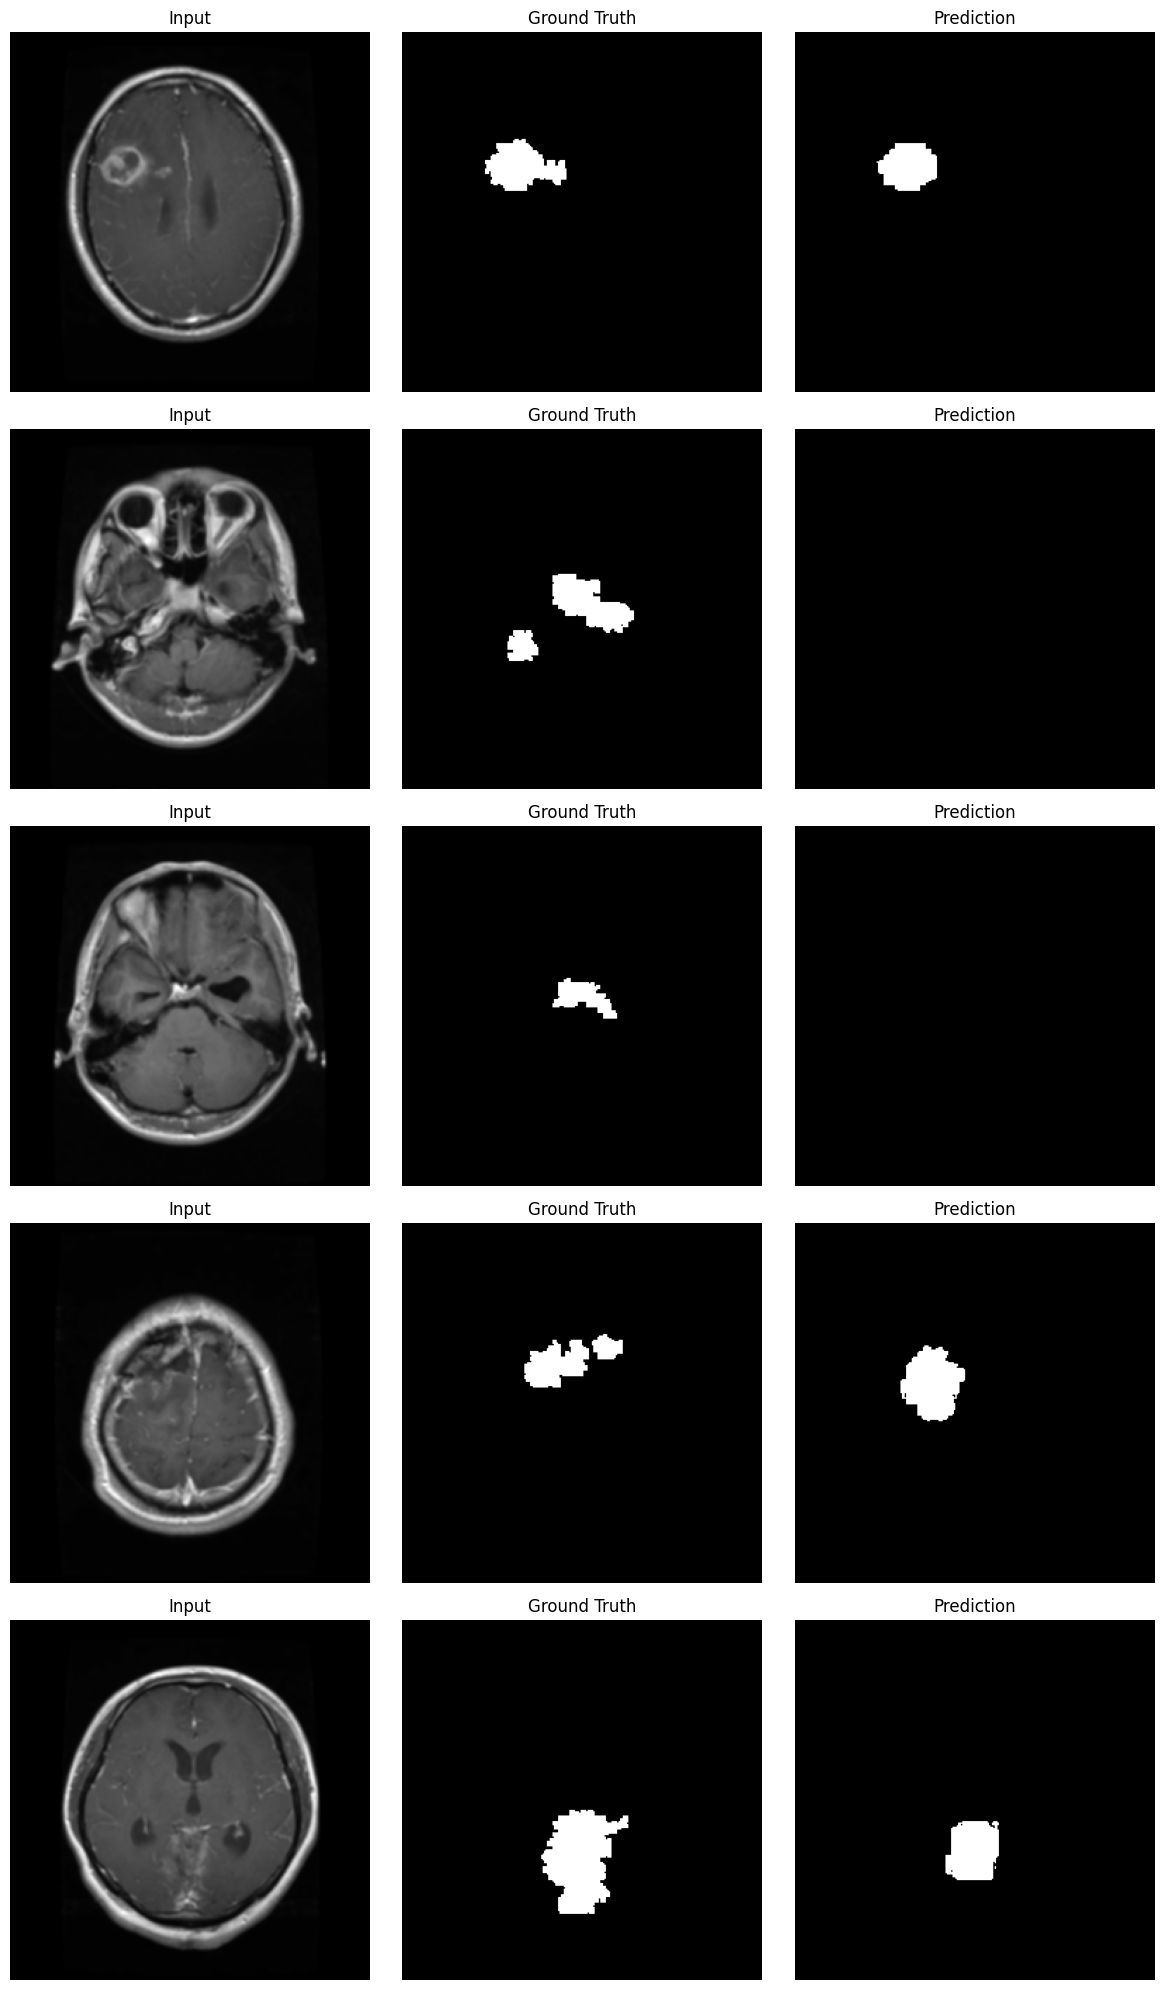


==== Final Segmentation Report ====
Dice Coefficient : 0.8389
Mean IoU         : 0.8596
Pixel Accuracy   : 0.9923



(0.8389429759096216, 0.8596003099724099, 0.9923221711759214)

In [12]:
# Segmentation Model
seg_model = SegmentationUNet().to(device)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs for Segmentation Model")
    seg_model = nn.DataParallel(seg_model)

seg_optimizer = optim.Adam(seg_model.parameters(), lr=LEARNING_RATE)

if os.path.exists(CHECKPOINT_PATH_SEG):
    load_checkpoint(CHECKPOINT_PATH_SEG, seg_model)

print("Training Segmentation Model")
train_model(
    seg_model, seg_train_dataloader, None,
    seg_val_dataloader, None,
    seg_criterion, None, seg_optimizer,
    NUM_EPOCHS, device,
    model_type="seg",
    checkpoint_path=CHECKPOINT_PATH_SEG,
    patience=5
)

print("Visualizing Segmentation Model")
visualize_predictions(seg_model, seg_val_dataloader, "seg", device, n_images=5)


# ================= Evaluation Report =================
def evaluate_segmentation(model, dataloader, device):
    model.eval()
    dice, miou, pixel_acc = 0.0, 0.0, 0.0

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            dice += dice_metric(outputs, masks)
            miou += miou_metric(outputs, masks)
            pixel_acc += pixel_accuracy(outputs, masks)

    avg_dice = dice / len(dataloader)
    avg_miou = miou / len(dataloader)
    avg_pixel_acc = pixel_acc / len(dataloader)

    print("\n==== Final Segmentation Report ====")
    print(f"Dice Coefficient : {avg_dice:.4f}")
    print(f"Mean IoU         : {avg_miou:.4f}")
    print(f"Pixel Accuracy   : {avg_pixel_acc:.4f}")
    print("=================================\n")

    return avg_dice, avg_miou, avg_pixel_acc

evaluate_segmentation(seg_model, seg_val_dataloader, device)


In [13]:
# # Classification Model
# cls_model = ClassificationUNet().to(device)
# if torch.cuda.device_count() > 1:
#     print(f"Using {torch.cuda.device_count()} GPUs for Classification Model")
#     cls_model = nn.DataParallel(cls_model)
# cls_optimizer = optim.Adam(cls_model.parameters(), lr=LEARNING_RATE)
# if os.path.exists(CHECKPOINT_PATH_CLS):
#     load_checkpoint(CHECKPOINT_PATH_CLS, cls_model)
# print("Training Classification Model")
# train_model(
#     cls_model, None, cls_train_dataloader,
#     None, cls_val_dataloader,
#     None, cls_criterion, cls_optimizer,
#     NUM_EPOCHS, device,
#     model_type="cls",
#     checkpoint_path=CHECKPOINT_PATH_CLS,
#     patience=5           # <-- NEW
# )
# print("Visualizing Classification Model")
# visualize_predictions(cls_model, cls_val_dataloader, "cls", device, n_images=5)  # <-- NEW

In [14]:
# # Joint Model
# joint_model = JointUNet().to(device)
# if torch.cuda.device_count() > 1:
#     print(f"Using {torch.cuda.device_count()} GPUs for Joint Model")
#     joint_model = nn.DataParallel(joint_model)
# joint_optimizer = optim.Adam(joint_model.parameters(), lr=LEARNING_RATE)
# if os.path.exists(CHECKPOINT_PATH_JOINT):
#     load_checkpoint(CHECKPOINT_PATH_JOINT, joint_model)
# print("Training Joint Model")
# train_model(
#     joint_model, seg_train_dataloader, cls_train_dataloader,
#     seg_val_dataloader, cls_val_dataloader,
#     seg_criterion, cls_criterion, joint_optimizer,
#     NUM_EPOCHS, device,
#     model_type="joint",
#     checkpoint_path=CHECKPOINT_PATH_JOINT,
#     patience=5           # <-- NEW
# )
# print("Visualizing Joint Model")
# visualize_predictions(joint_model, seg_val_dataloader, "joint", device, n_images=5)  # <-- NEW